In [146]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import pyplot as plt
%matplotlib widget

class Prob:
    def __init__(self, instances, sigx, sigz, radius):

        self.sigx = sigx
        self.sigz = sigz
        self.radius = radius

        self.instances = instances
        t = np.linspace(0, 2 * np.pi, instances + 1)[0:instances]
        self.c_k = np.vstack([radius * np.cos(t), radius * np.sin(t)]).T[None,:,:,None]

        Q = np.array([[-radius * np.sin(t), radius * np.cos(t)], [radius * np.cos(t), radius * np.sin(t)]])
        D = np.diag(np.array([sigx[0], sigx[1]]))
        self.sig = (np.einsum('ilk,ljk->ijk', np.einsum('ijk,lj->ilk', Q, D), Q)).transpose(2, 0, 1)[None]
        self.L_sig = np.linalg.cholesky(self.sig)


    def p_X(self, x):  # Joint P(X,Z)
        xhat = (self.c_k - x[:,None])
        mah = np.einsum('ncik,ncik->nck', np.einsum('ncij,ncjk->ncik', np.linalg.inv(self.sig), xhat), xhat)
        p = 1 / (2 * np.pi) * np.linalg.det(self.sig)[:,:, None] ** (-.5) * np.exp(-.5 * (mah))

        return np.mean(p, 1)

    def p_Z(self, z):  # Joint P(X,Z)
        sig_tmp = self.sig + np.eye(2) * self.sigz
        xhat = (self.c_k - z[:,None])
        mah = np.einsum('ncik,ncik->nck', np.einsum('ncij,ncjk->ncik', np.linalg.inv(sig_tmp), xhat), xhat)
        p = 1 / (2 * np.pi) * np.linalg.det(sig_tmp)[:, :, None] ** (-.5) * np.exp(-.5 * (mah))

        return np.mean(p, 1)

    def w_XgZ(self, z):  # w_X|Z posterior weights of each component

        sig_tmp = self.sig + np.eye(2) * self.sigz
        xhat = (self.c_k - z[:, None])
        mah = np.einsum('ncik,ncik->nck', np.einsum('ncij,ncjk->ncik', np.linalg.inv(sig_tmp), xhat), xhat)
        p = 1 / (2 * np.pi) * np.linalg.det(sig_tmp)[:,:, None] ** (-.5) * np.exp(-.5 * (mah))
        return p / np.mean(p, 1,keepdims=True) / self.instances

    def mu_XgZ(self, z):  # posterior means of each component
        mu_list = self.c_k + (self.sig @ np.linalg.inv(self.sig + np.eye(2) * self.sigz)) @ (z[:,None] - self.c_k)
        return mu_list

    def sig_XgZ(self):  # posterior means of each component
        sig_list = self.sig - self.sig @ np.linalg.inv(self.sig + np.eye(2) * self.sigz) @ self.sig
        return sig_list

    def p_XgZ(self, x, z):  # Posterior P(X|Z)

        w_XgZ = self.w_XgZ(z)
        mu_XgZ = self.mu_XgZ(z)
        sig_XgZ = self.sig_XgZ()

        xhat = (mu_XgZ - x[:,None])
        mah = np.einsum('ncik,ncik->nck', np.einsum('ncij,ncjk->ncik', np.linalg.inv(sig_XgZ), xhat), xhat)
        p = 1 / (2 * np.pi) * np.linalg.det(sig_XgZ)[:,:, None] ** (-.5) * np.exp(-.5 * (mah))

        return np.sum(w_XgZ * p, 1)

    def p_marg_XgZ(self, x, z):  # Marginal Posteriors P(X1|Z)  P(X2|Z)

        w_XgZ = self.w_XgZ(z)[:, :, None]
        mu_XgZ = self.mu_XgZ(z)
        sig_XgZ = self.sig_XgZ()
        
        sig_marg = sig_XgZ[:,:,np.arange(2),np.arange(2)][:,:,:,None]
        xhat = (mu_XgZ-x[:,None,None,None])

        mah = xhat ** 2 / sig_marg
        p = np.sum(w_XgZ * (1 / (2 * np.pi * sig_marg) * np.exp(-.5 * (mah))), 1)

        return p
    
    def p_marg_XgZ(self, x, z):  # Marginal Posteriors P(X1|Z)  P(X2|Z)

        w_XgZ = self.w_XgZ(z)[:, :, None]
        mu_XgZ = self.mu_XgZ(z)
        sig_XgZ = self.sig_XgZ()
        
        sig_marg = sig_XgZ[:,:,np.arange(2),np.arange(2)][:,:,:,None]
        xhat = (mu_XgZ-x[:,None,None,None])

        mah = xhat ** 2 / sig_marg
        p = np.sum(w_XgZ * (1 / (2 * np.pi * sig_marg) * np.exp(-.5 * (mah))), 1)

        return p
    
    def p_marg_X(self, x):  # Marginal Posteriors P(X1|Z)  P(X2|Z)
        
        sig = self.sig[:,:,np.arange(2),np.arange(2)][:,:,:,None]
        xhat = (self.c_k-x[:,None,None,None])

        mah = xhat ** 2 / sig
        p = np.sum(1/self.instances * (1 / (2 * np.pi * sig) * np.exp(-.5 * (mah))), 1)

        return p
    
    
    def p_marg_Z(self, z):  # Marginal Posteriors P(X1|Z)  P(X2|Z)
        
        sig = self.sig[:,:,np.arange(2),np.arange(2)][:,:,:,None]+self.sigz
        xhat = (self.c_k-z[:,None,None,None])

        mah = xhat ** 2 / sig
        p = np.sum(1/self.instances * (1 / (2 * np.pi * (sig+self.sigz)) * np.exp(-.5 * (mah))), 1)

        return p
    
    def w_marg_XgZ(self,z):
        
        sig = self.sig[:,:,np.arange(2),np.arange(2)][:,:,:,None]+self.sigz
        xhat = (self.c_k-z[:,None,None,None])

        mah = xhat ** 2 / sig
        p =1/self.instances * (1 / (2 * np.pi * (sig+self.sigz)) * np.exp(-.5 * (mah)))
        
        return p/np.mean(p,1,keepdims=True)/self.instances
    
    def mu_marg_Xgz(self,z):
        sig = self.sig[:,:,np.arange(2),np.arange(2)][:,:,:,None]
        sigz = self.sig[:,:,np.arange(2),np.arange(2)][:,:,:,None]+self.sigz
        mu_list = self.c_k + sig/sigz * (z[:,None] - self.c_k)
        
        return mu_list
        
    
    def p_XgZ_marg(self, x, z):  # Marginal Posteriors P(X1|Z1)  P(X2|Z1)

        w_XgZ = self.w_marg_XgZ(z)#[:, :, None]
        mu_XgZ = self.mu_marg_Xgz(z)
        sig_XgZ = self.sig_XgZ()
        
        sig_marg = sig_XgZ[:,:,np.arange(2),np.arange(2)][:,:,:,None]
        xhat = (mu_XgZ-x[:,None,None,None])

        mah = xhat ** 2 / sig_marg
        p = np.sum(w_XgZ * (1 / (2 * np.pi * sig_marg) * np.exp(-.5 * (mah))), 1)

        return p
        

    def exp_XgZ(self, z):  # posterior mean
        w_XgZ = self.w_XgZ(z)[:, :, None]
        mu_list = self.c_k + (self.sig @ np.linalg.inv(self.sig + np.eye(2) * self.sigz)) @ (z[:,None] - self.c_k)
        return np.sum(w_XgZ * mu_list, 1)

    def var_XgZ(self, z):  # Posterior Variance

        w_XgZ = self.w_XgZ(z)[:, :, None]
        exp_XgZ = self.exp_XgZ(z)
        mu_XgZ = self.mu_XgZ(z)
        sig_XgZ = self.sig_XgZ()

        var = np.sum(w_XgZ * (sig_XgZ + mu_XgZ @ mu_XgZ.transpose(0,1, 3, 2)), 1)

        return var - exp_XgZ@exp_XgZ.transpose(0,2,1)

    def direct_posterior_sampling(self, num_data):

        idx = np.random.choice(np.arange(self.instances), num_data)
        x = self.c_k[0, idx][:, None] + np.einsum('ncij,nj->nci', self.L_sig[0, idx][:, None], np.random.randn(num_data, 2))[:,:,:,None]
        z_given_x = np.random.randn(num_data, 1, 2, 1) * np.sqrt(self.sigz) + x
        

        var = self.var_XgZ(z_given_x[:, 0])[:, np.arange(2), np.arange(2)].ravel()
        exp = self.exp_XgZ(z_given_x[:, 0])
        err = ((x[:, 0] - exp) ** 2).ravel()

        return x.squeeze(), z_given_x.squeeze(), exp.squeeze(), var, err
    
    
    def unifomr_circle_sampling(self, num_data):
        

        #t = np.linspace(0, 2 * np.pi, num_data + 1)[0:num_data]
        t = np.random.rand(num_data)*2 * np.pi
        x = np.vstack([radius * np.cos(t), radius * np.sin(t)]).T[:,None,:,None]
                
        z_given_x = np.random.randn(num_data, 1, 2, 1) * np.sqrt(prob.sigz) + x

        var = prob.var_XgZ(z_given_x[:, 0])[:, np.arange(2), np.arange(2)].ravel()
        exp = prob.exp_XgZ(z_given_x[:, 0])
        err = ((x[:, 0] - exp) ** 2).ravel()

        return x.squeeze(), z_given_x.squeeze(), exp.squeeze(), var, err
    
    def empirical_posterior_sampling(self, num_data, num_posterior):
        err_list = []
        var_list = []
        err_list2 = []
        var_list2 = []
        z_list = []
        post_list = []
        x_list = []
        exp_list = []

        for i in range(num_data):
            if i % 10000 == 0: print(str(i) + ' | ' + str(num_data))

            idx = np.random.choice(np.arange(len(prob.c_k)), 1)[0]
            x = self.c_k[idx] + self.L_sig[idx] @ np.random.randn(2, 1)

            z_given_x = np.random.randn(2, 1) * np.sqrt(self.sigz) + x

            #             w_XgZ = self.w_XgZ(z_given_x)
            #             idp = np.random.choice(np.arange(len(prob.c_k)),num_posterior,p = np.array(w_XgZ)[:,0])

            #             posterior_means =  np.array(self.mu_XgZ(z_given_x)).squeeze()[idp]
            #             posterior_vars =  np.array(self.sig_XgZ()).squeeze()[idp]
            #             posterior=posterior_means+np.einsum('nji,ni->nj',np.linalg.cholesky(posterior_vars),np.random.randn(num_posterior,2))

            #             err_list.append((np.mean(posterior,0,keepdims=True).T-x)**2)
            #             var_list.append(np.var(posterior,0))

            #             exp_list.append(np.mean(posterior,0))

            z_list.append(z_given_x)
            err_list.append((self.exp_XgZ(z_given_x) - x) ** 2)
            var_list.append(self.var_XgZ(z_given_x))
            post_list.append(self.exp_XgZ(z_given_x))
            x_list.append(x)

        return x_list, z_list, post_list, var_list, err_list  # , var_list2, err_list2#x_list,z_list,post_list, var_list, err_list, var_list2, err_list2

    @staticmethod  # Univariate Gaussian PDF
    def gauss(x, mu, sig):
        return 1 / np.sqrt(2 * np.pi * sig) * np.exp(-0.5 * (x - mu) ** 2 / sig)

    @staticmethod  # Bivariate Gaussian PDF
    def multivariate_gauss(x, mu, sig):

        return 1 / (2 * np.pi) * np.linalg.det(sig) ** (-.5) * np.exp( -.5 * (np.einsum('ij,ji->i', (x - mu).T, np.linalg.inv(sig) @ (x - mu))))
    
    def posterior_sampling_julius(self, y, n_samples):
        # compute mean and convariance of the posterior
        self.post_mu = []
        self.post_sig = []
        self.post_cholesky = []
        for i in range(self.instances):
            mu_data = self.c_k[0, i]
            sig_data = self.sig[0, i]
            print(self.sigz)
            mu_post = mu_data + sig_data @ np.linalg.inv(sig_data + np.eye(2)*self.sigz) @ (y - mu_data)
            self.post_mu.append(mu_post[0])
            sig_post = sig_data - sig_data @ np.linalg.inv(sig_data + np.eye(2) * self.sigz) @ sig_data
            self.post_sig.append(sig_post)
            self.post_cholesky.append(np.linalg.cholesky(sig_post))
            
        self.post_mu = np.array(self.post_mu)[None]
        print(self.post_mu)
        self.post_sig = np.array(self.post_sig)[None]
        # self.post_mu = self.mu_XgZ(y)
        # self.post_sig = self.sig_XgZ()

        # print(self.post_sig_ju - self.post_sig)
        self.post_cholesky = np.linalg.cholesky(self.post_sig)

        # sample index of the component
        p_y = self.w_XgZ(y)
        idx = np.array(np.random.choice(list(range(self.instances)), n_samples, p=p_y.squeeze()))
        # sample from the posterior
        x = self.post_mu[0,idx,...,0] + np.einsum('nij,nj->ni', self.post_cholesky[0,idx], np.random.randn(n_samples, 2))
        return x


(1, 2, 1)
(1, 2, 1)
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
[[[[ 1.0268367 ]
   [ 0.30379702]]

  [[ 0.80356144]
   [ 0.72035174]]

  [[ 0.38700672]
   [ 0.98523184]]

  [[-0.22305135]
   [ 0.9138551 ]]

  [[-0.63982997]
   [ 0.30379702]]

  [[-0.37494986]
   [-0.45815957]]

  [[ 0.38700672]
   [-0.68143482]]

  [[ 0.95545995]
   [-0.26465621]]]]


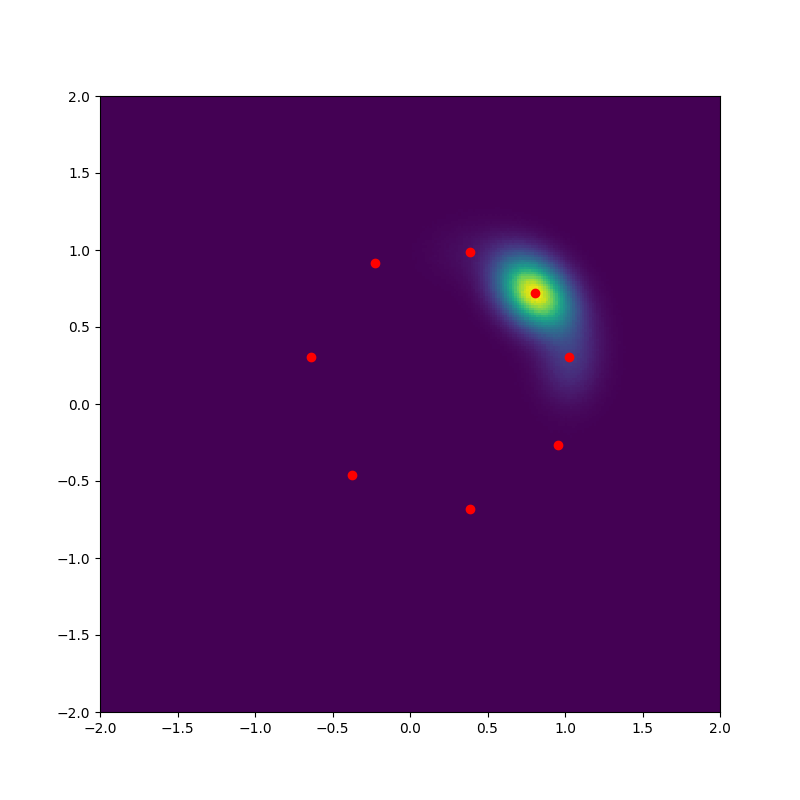

In [161]:
y = np.array([[1.],[0.5]])[None]
print(y.shape)
y = np.array([[1.16102017], [0.91139106]])[None]
print(y.shape)

sigx = [5e-2,2e-2]#[1e-2,1e-4]#1e-3]
radius = 1
sigz = 0.1
res = 256
instances = 8
prob = Prob(instances,sigx,sigz,radius)
idx = np.random.choice(list(range(8)), 10)
samples = prob.posterior_sampling_julius(y, 10000000)

# plot
fig = plt.figure(figsize=(8,8))
#plot between -2 and 2 with .001 steps.
plt.hist2d(samples[:,0], samples[:,1], bins=256, cmap='viridis', range=[[-2,2],[-2,2]])
post_mu = prob.post_mu[0]
plt.scatter(post_mu[:,0], post_mu[:,1], c='r')
plt.show()




(1, 2, 1)


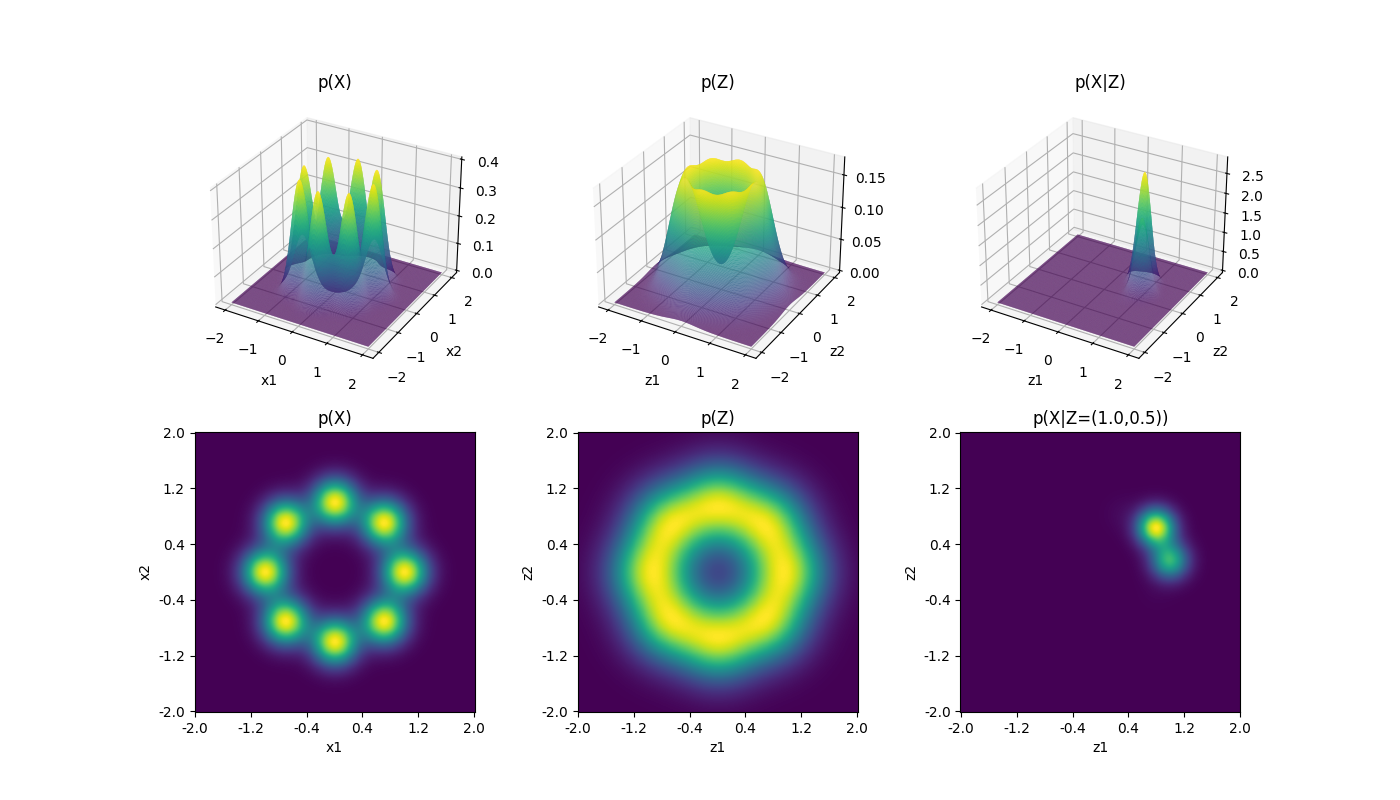

In [148]:


sigx = [5e-2,5e-2]#[1e-2,1e-4]#1e-3]
radius = 1
sigz = 0.1
res = 256
instances = 8

xmin = -2
xmax = 2
    

prob = Prob(instances,sigx,sigz,radius)
Z = np.array([[[1.],[.5]]])
print(Z.shape)

yy, xx = np.mgrid[xmax:xmin:res*1j, xmin:xmax:res*1j]
positions = np.vstack([xx.ravel(), yy.ravel()]).T[:,:,None]

zzpx = prob.p_X(positions).reshape(xx.shape)
zzpz = prob.p_Z(positions).reshape(xx.shape)
zzpxgz = prob.p_XgZ(positions,Z).reshape(xx.shape)

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(2, 3, 1, projection='3d')
surf = ax.plot_surface(xx, yy, zzpx, rstride=1, cstride=1, cmap='viridis', edgecolor='none', rasterized=True)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('p(X)')

ax = fig.add_subplot(2, 3, 2, projection='3d')
surf = ax.plot_surface(xx, yy, zzpz, rstride=1, cstride=1, cmap='viridis', edgecolor='none', rasterized=True)
ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_title('p(Z)')

ax = fig.add_subplot(2, 3, 3, projection='3d')
surf = ax.plot_surface(xx, yy, zzpxgz, rstride=1, cstride=1, cmap='viridis', edgecolor='none', rasterized=True)
ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_title('p(X|Z)')


ax = fig.add_subplot(2, 3, 4)
#cfset = ax.contourf(xx, yy, zz, cmap='viridis')
#cset = ax.contour(xx, yy, zz, colors='k')
ax.imshow(zzpx)
#ax.clabel(cset, inline=1, fontsize=12)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('p(X)')

ax.set_xticks(list(np.linspace(0,res-1,6).astype(int)))
ax.set_xticklabels(list(np.round(np.linspace(xmin,xmax,6),2)))
ax.set_yticks(list(np.linspace(0,res-1,6).astype(int)))
ax.set_yticklabels(np.round(np.linspace(xmax,xmin,6),2))

ax = fig.add_subplot(2, 3, 5)
#cfset = ax.contourf(xx, yy, zz, cmap='viridis')
#cset = ax.contour(xx, yy, zz, colors='k')
ax.imshow(zzpz)
#ax.clabel(cset, inline=1, fontsize=12)
ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_title('p(Z)')

ax.set_xticks(list(np.linspace(0,res-1,6).astype(int)))
ax.set_xticklabels(list(np.round(np.linspace(xmin,xmax,6),2)))
ax.set_yticks(list(np.linspace(0,res-1,6).astype(int)))
ax.set_yticklabels(np.round(np.linspace(xmax,xmin,6),2))

ax = fig.add_subplot(2, 3, 6)
#cfset = ax.contourf(xx, yy, zz, cmap='viridis')
#cset = ax.contour(xx, yy, zz, colors='k')
ax.imshow(zzpxgz)
#ax.plot(Z*res,'x')
#ax.clabel(cset, inline=1, fontsize=12)
ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_title('p(X|Z=('+str(Z[0][0][0])+','+str(Z[0][1][0])+'))')

ax.set_xticks(list(np.linspace(0,res-1,6).astype(int)))
ax.set_xticklabels(list(np.round(np.linspace(xmin,xmax,6),2)))
ax.set_yticks(list(np.linspace(0,res-1,6).astype(int)))
ax.set_yticklabels(np.round(np.linspace(xmax,xmin,6),2))

plt.savefig('PDF.pdf',bbox_inches='tight')



In [84]:
prob.post_sig.shape
prob.post_mu.shape
# prob.post_cholesky.shape


AttributeError: 'Prob' object has no attribute 'post_sig'